# LIBRARIES

In [15]:
import catboost as cb
import config
import logging
import matplotlib.pyplot as plt
from model import model_train
import numpy as np
import optuna
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.stats import skew
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
%matplotlib inline

# LOGGING

In [2]:
# preparing logging
logging.basicConfig(filename=config.LOG_FILES_TRAIN,
                    level=logging.DEBUG,
                    filemode='a',
                    format='%(asctime)s %(levelname)s %(name)s  %(message)s')
logger = logging.getLogger()

# DATA PRE-PROCESSING

In [3]:
# Load Dataset
logger.info('Reading in dataset')
df = pd.read_csv(config.TRAINING_FILE, sep=';', index_col='id')
df.head()
logger.info('Successfully converted days to years')

In [4]:
# CONVERT AGE FROM DAYS TO YEARS
logger.info('Convert age from days to years')
age_year = df['age'].apply(lambda x: x/365)
df['age'] = np.ceil(age_year)
logger.info('Successful')

# EDA

In [5]:
# Summary of the dataset
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000
mean,53.837953,1.349519,164.362217,74.203027,128.829584,96.650092,1.366806,1.226447,0.088051,0.053881,0.803986,0.499589
std,6.766743,0.476821,8.205337,14.383469,154.775805,189.096240,0.680270,0.572246,0.283371,0.225784,0.396982,0.500003
min,30.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,49.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,59.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,65.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


## EDA INFERENCES  


### The dataset contains adults ranging from 30 - 65 years of age, therefore we can make some assumptions to treat outliers.


#### 1. Min height in the dataset is 55cm, Max height 250cm

        We will assume the lower limit to be 140cm and upper limit to be 185cm.

#### 2. Min weight in the dataset is 10kg, Max weight 200kg

        We will assume the lower limit to be 45kg and upper limit to be 130 kg.

#### 3. ap_hi (Systolic pressure) ranges from 90mm/Hg to 120mm/Hg according to scientific publications
        https://www.medicinenet.com/blood_pressure_chart_reading_by_age/article.htm.

        We will assume the lower limit as 90mm/Hg and upper limit to 180mm/Hg to accomodate for hypertensive participants

#### 4. ap_lo (Diastolic pressure) ranges from 60mm/Hg to 80mm/Hg according to scientific publications.

        We will assume the lower limit as 60mm/Hg and upper limit to 120mm/Hg to accomodate or hypertensive participants

#### 5. Convert negative systolic and diastolic blood pressure by multiplying it by -1


# FEATURE ENGINEERING

In [6]:
# CONVERT NEGATIVE AP_HI AN AP_LO TO POSTIVE VALUES
df.loc[(df['ap_hi'] < 0), "ap_hi"].apply(lambda x: (x*-1))
df.loc[(df['ap_lo'] < 0), "ap_lo"].apply(lambda x: (x*-1))


# CONVERT OUTLIERS IN DF TO NAN VALUES
df.loc[(df['ap_hi'] < 90) | (df['ap_hi'] > 180), "ap_hi"] = np.nan
df.loc[(df['ap_lo'] < 60) | (df['ap_lo'] > 120), "ap_lo"] = np.nan
df.loc[(df['weight'] < 60) | (df['weight'] > 120), "weight"] = np.nan
df.loc[(df['height'] < 120) | (df['height'] > 192), "height"] = np.nan

logger.info('Dropping NaN values')
#  DROP NAN VALUES
df = df.dropna()
logger.info('All NAN values are dropped')

In [7]:
# target
target = df.cardio


# transformed dataset
df_train = df.drop(['cardio'], axis=1)

#### CHECK FOR SKEWNESS

In [8]:
for colname in df_train:
    print(f'{colname} : {skew(df_train[{colname}])}')

age : [-0.31570748]
gender : [0.54228394]
height : [-0.03703565]
weight : [0.94092863]
ap_hi : [0.77908564]
ap_lo : [0.27602608]
cholesterol : [1.56659088]
gluc : [2.35771822]
smoke : [2.8546815]
alco : [3.89005522]
active : [-1.51548973]


#### PLOT SKEWNESS

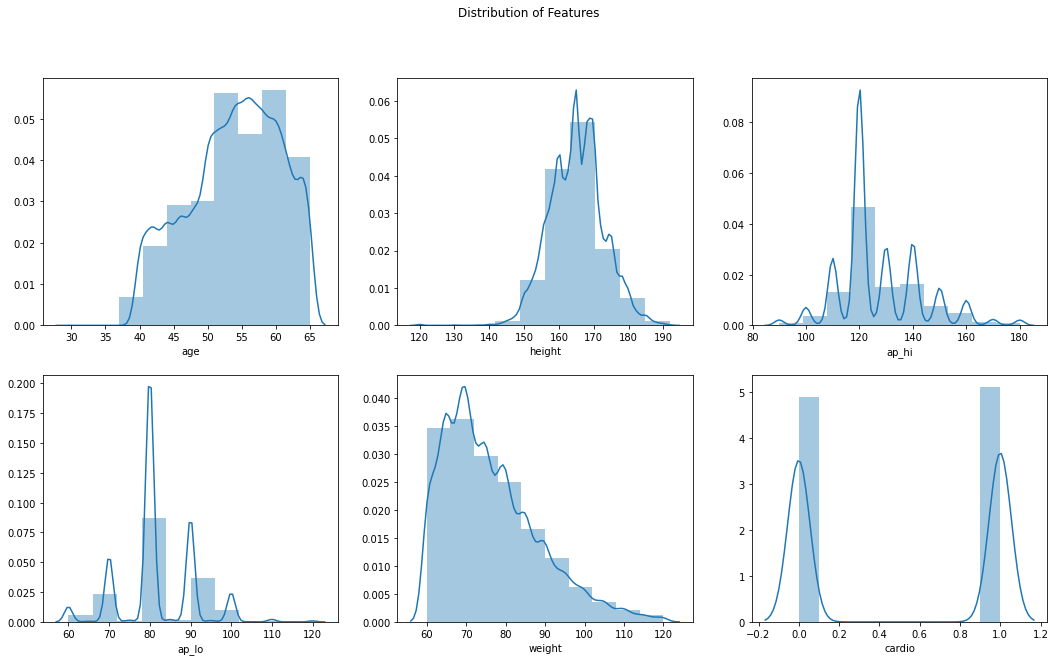

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('Distribution of Features')

sns.distplot(df_train.age,bins=10, ax=axes[0, 0])
sns.distplot(df_train.height,bins=10, ax=axes[0, 1])
sns.distplot(df_train.ap_hi,bins=10, ax=axes[0, 2])
sns.distplot(df_train.ap_lo,bins=10, ax=axes[1, 0])
sns.distplot(df_train.weight,bins=10, ax=axes[1, 1])
sns.distplot(target,bins=10, ax=axes[1, 2])

#### CORRELATION WITH TARGET VARIABLE

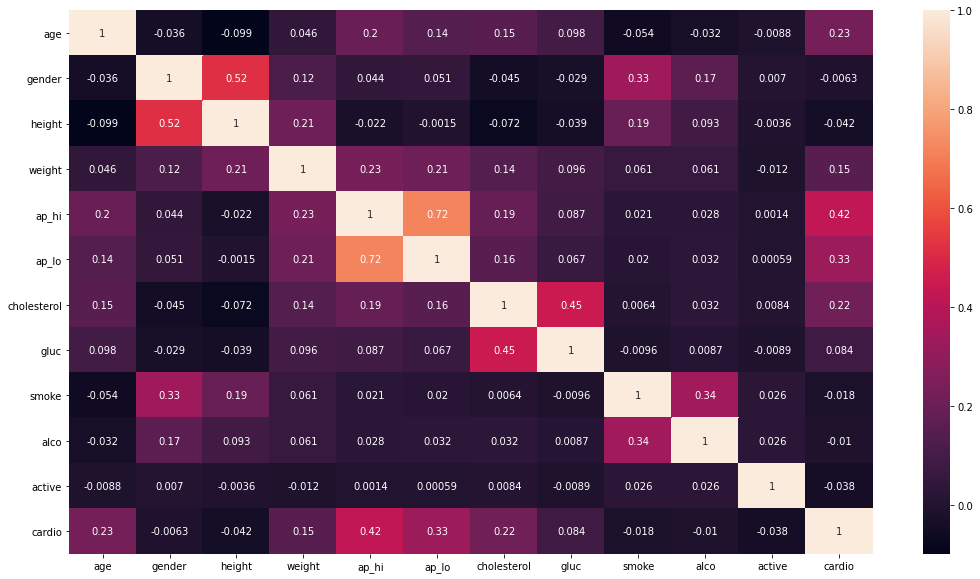

In [10]:
plt.figure(figsize=(18,10))
sns.heatmap(df.corr(),annot=True)

#### CORRECT SKEWNESS

In [11]:
df_train['weight_normalized'] = np.sqrt(df.weight)
# df['age_normalized'] = np.square(df.age)
# df['ap_lo_normalized'] = np.sqrt(df.ap_lo)
df_train['ap_hi_normalized'] = np.sqrt(df.ap_hi)

### FEATURE SELECTION

In [12]:
# Now that we've transformed the data, we will select the top 5 features for our model.
df_train = df_train.drop(['weight','ap_hi'], axis=1)
model = ExtraTreesClassifier()
model.fit(df_train, target)
Feature_Importance = pd.Series(model.feature_importances_, index=df_train.columns)
best_feat = Feature_Importance.nlargest(5)
# print(best_feat)
feat_index = best_feat.index
df_train = df_train.filter(items=list(feat_index), axis=1)
df_train = df_train.astype('int')

In [13]:
print('The selected columns are:')
for col_name in df_train.columns:
    print(col_name)


The selected columns are:
height
weight_normalized
ap_hi_normalized
age
ap_lo


# MODEL TRAINING

### BASELINE MODELS

In [15]:
# Model Training
# logger.info('Model Training')
model_train(df_train=df_train,target=target)

Logistic Regession: The F1_score is 0.6942894749494415
Random Forest Classifier: The F1_score is 0.665412674245932
Support Vector Clasifier: The F1_score is 0.6860088781903718
K-Nearest Neighbour: The F1_score is 0.6679652312670356
Catboost: The F1_score is 0.7113321417772723
XGBoost: The F1_score is 0.7138944470407403


# HYPER PARAMETER TUNING

https://www.kaggle.com/saurabhshahane/catboost-hyperparameter-tuning-with-optuna?cellIds=9&kernelSessionId=81896312

In [19]:
def objective(trial):
    # train_x, valid_x, train_y, valid_y = train_test_split(df_train,target, test_size=0.3)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        )
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param,early_stopping_rounds=25,silent=True)

    score = cross_val_score(gbm, df_train, target, n_jobs=-1, cv=3, scoring='f1')
    f1_score= score.mean()

    # gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0)

    # preds = gbm.predict(valid_x)
    # pred_labels = np.rint(preds)
    # accuracy = f1_score(valid_y, pred_labels)
    return f1_score

In [20]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-03-20 02:17:10,559] Trial 0 finished with value: 0.6898350195716589 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07779770058373905, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.995487697297316}. Best is trial 0 with value: 0.6898350195716589.
[I 2022-03-20 02:19:58,661] Trial 1 finished with value: 0.6877221822355274 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.029943518563585028, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.6898350195716589.
[I 2022-03-20 02:22:49,974] Trial 2 finished with value: 0.6999568129690869 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06660269037165582, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.907174857487325}. Best is trial 2 with value: 0.6999568129690869.
[I 2022-03-20 02:23:44,580] Trial 3 finished with value: 0.6875979900898844 an

In [23]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.711034852145607
  Params: 
    objective: Logloss
    colsample_bylevel: 0.09984522293864019
    depth: 10
    boosting_type: Plain
    bootstrap_type: MVS


# Re-train and Saving the Model

In [17]:
param = {
    'objective': 'Logloss',
    'colsample_bylevel': 0.09984522293864019,
    'depth': 10,
    'boosting_type': 'Plain',
    'bootstrap_type': 'MVS'
}


clf = cb.CatBoostClassifier(**param)
clf.fit(df_train,target)


Learning rate set to 0.058819
0:	learn: 0.6900821	total: 679ms	remaining: 11m 18s
1:	learn: 0.6900568	total: 708ms	remaining: 5m 53s
2:	learn: 0.6900344	total: 728ms	remaining: 4m 2s
3:	learn: 0.6796045	total: 754ms	remaining: 3m 7s
4:	learn: 0.6795884	total: 774ms	remaining: 2m 33s
5:	learn: 0.6795742	total: 791ms	remaining: 2m 10s
6:	learn: 0.6778113	total: 810ms	remaining: 1m 54s
7:	learn: 0.6671100	total: 832ms	remaining: 1m 43s
8:	learn: 0.6671006	total: 850ms	remaining: 1m 33s
9:	learn: 0.6670922	total: 870ms	remaining: 1m 26s
10:	learn: 0.6670848	total: 893ms	remaining: 1m 20s
11:	learn: 0.6670782	total: 919ms	remaining: 1m 15s
12:	learn: 0.6597122	total: 958ms	remaining: 1m 12s
13:	learn: 0.6597076	total: 1s	remaining: 1m 10s
14:	learn: 0.6589795	total: 1.05s	remaining: 1m 8s
15:	learn: 0.6589759	total: 1.08s	remaining: 1m 6s
16:	learn: 0.6584136	total: 1.11s	remaining: 1m 4s
17:	learn: 0.6584109	total: 1.15s	remaining: 1m 2s
18:	learn: 0.6579136	total: 1.18s	remaining: 1m
19:	

In [18]:
pickle.dump(clf,open('../models/clf_catboost_model.pkl','wb'))